# Quantum Fourier Transform: Ferris's algorithm

-- Works for the one particle subspace only

Ref: Fourier transform of fermionic systems and the spectral tensor network Andrew Ferris


In [48]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.circuit import Parameter
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from IPython.core.interactiveshell import InteractiveShell
from scipy.sparse import csr_matrix
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.visualization import array_to_latex
InteractiveShell.ast_node_interactivity = "all"

In [49]:
is_ionq=0
is_ibmq=1
if is_ionq:
    provider = AzureQuantumProvider(
      resource_id="/subscriptions/0915759d-f6c8-4264-a634-e3845356e2a0/resourceGroups/Syracuse-U1/providers/Microsoft.Quantum/Workspaces/test4fermi",
      location="East US"
    )
    print([backend.name() for backend in provider.backends()])
    
elif is_ibmq:
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q-bnl', group='bnl-non-c2qa-pro', project='exploring-fundam')
    print([backend.name() for backend in provider.backends()])
else:
    print(Aer.backends())

ibmqfactory.load_account:WARNING:2023-10-24 01:46:33,173: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

['ibmq_qasm_simulator', 'ibmq_kolkata', 'ibmq_mumbai', 'ibmq_guadalupe', 'simulator_statevector', 'simulator_mps', 'simulator_extended_stabilizer', 'simulator_stabilizer', 'ibm_hanoi', 'ibm_algiers', 'ibm_lagos', 'ibm_nairobi', 'ibm_cairo', 'ibm_auckland', 'ibm_perth', 'ibm_sherbrooke', 'ibm_brisbane', 'ibm_nazca', 'ibm_cusco']


# Create F operator
Fig S6 in Gustafson paper: "Real time qm calculations of phase shits"

$$
F=\left(\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 \\
0 & \frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}} & 0 \\
0 & 0 & 0 & -1
\end{array}\right)
$$

<IPython.core.display.Latex object>

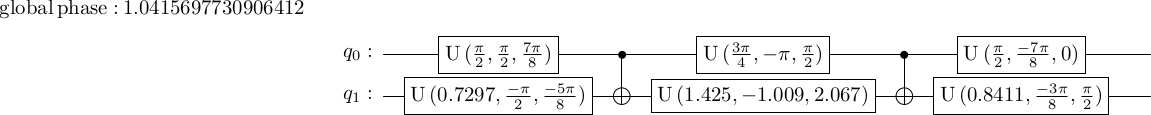

<IPython.core.display.Latex object>

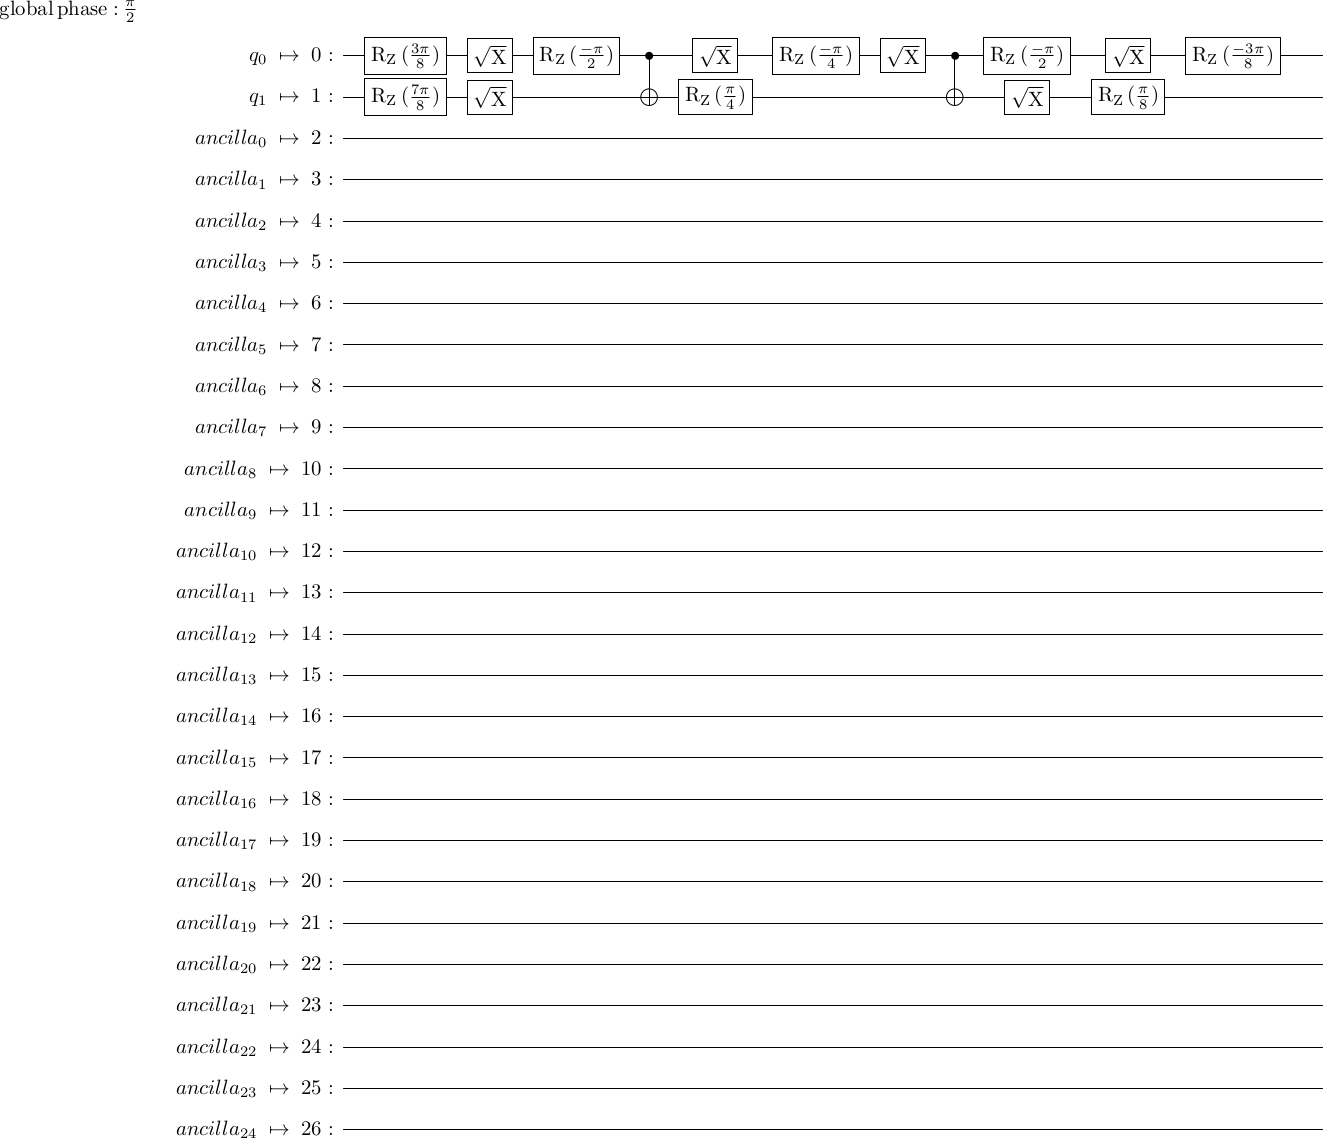

In [50]:


F = Operator([[1, 0, 0, 0], [0, 1/np.sqrt(2),1/np.sqrt(2), 0],[0, 1/np.sqrt(2), -1/np.sqrt(2), 0], [0, 0, 0, -1]])  # note that using decimal point causes 
                                                                    # error, as unitarity is violated, 
    #important to use 1/sqrt(2) to append the operator as circuit
    
array_to_latex(F.data)


#from qiskit.circuit import Gate, Instruction, Reset
tckt2 = QuantumCircuit(2)
tckt2.unitary(F,[0,1])
tckt2.decompose().draw('latex')

array_to_latex(Operator(tckt2))
backend=provider.get_backend("ibmq_kolkata")

transpiled_qc = transpile(tckt2, backend, optimization_level=0,initial_layout=[0,1])

transpiled_qc.draw('latex')


#print("meta", transpiled_qc.data)

#for gate in transpiled_qc.data:
#    print("new level")
#    print('\ngate name:', gate[0].name)
#    print('qubit(s) acted on:', gate[1])
#    print('other paramters (such as angles):', gate[0].params)
#    print('')



$U_i(\alpha,\beta,\gamma)$

|$U_i$|$\alpha$|$\beta$|$\gamma$|
|---|---|---|---|
|$U_1$ | $\frac{\pi}{2}$ | $-\frac{\pi}{2}$ |$-\frac{\pi}{8}$
|$U_2$ | $\frac{3\pi}{4}$ | $0$ |$\frac{\pi}{2}$
|$U_3$ | $\frac{\pi}{2}$ | $\frac{\pi}{8}$ |$0$
|$U_4$ | $0.05876$ | $-\frac{\pi}{2}$ |$-\frac{5\pi}{8}$
|$U_5$ | $1.588$ | $2.355$ |$-1.612$
|$U_6$ | $1.63$ | $\frac{5\pi}{8}$ |$-\frac{\pi}{2}$


# Create initial state for 8 qubit

In [51]:
test_ckt=QuantumCircuit(1)
p1=Parameter('theta')
p2=Parameter('phi')
p3=Parameter('lambda')

test_ckt.rz(p1,0)
test_ckt.rx(p2,0)
test_ckt.ry(p3,0)
test_ckt.draw()

┌───────────┐┌─────────┐┌────────────┐
q: ┤ Rz(theta) ├┤ Rx(phi) ├┤ Ry(lambda) ├
   └───────────┘└─────────┘└────────────┘

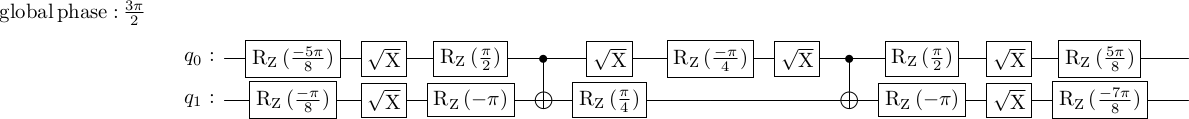

<IPython.core.display.Latex object>

In [64]:
def F_gate():
    tckt = QuantumCircuit(2)
    theta1=Parameter('')

    theta1=np.pi
    q0=0
    q1=1
    tckt.rz(-5/8*theta1,q0)
    tckt.sx(q0)
    tckt.rz(0.5*theta1,q0)

    tckt.rz(-1/8*theta1,q1)
    tckt.sx(q1)
    tckt.rz(-theta1,q1)

    tckt.cx(q0,q1)
    tckt.sx(q0)
    tckt.rz(-0.25*theta1,q0)
    tckt.sx(q0)
    tckt.rz(0.25*theta1,q1)
    tckt.cx(q0,q1)


    tckt.rz(0.5*theta1,q0)
    tckt.sx(q0)
    tckt.rz(5/8*theta1,q0)

    tckt.rz(-theta1,q1)
    tckt.sx(q1)
    tckt.rz(-7/8*theta1,q1)


    return tckt


def Finv_gate():
    tckt = QuantumCircuit(2)
    theta1=Parameter('')

    theta1=-np.pi
    q0=0
    q1=1
    tckt.rz(-7/8*theta1,q1)
    tckt.sxdg(q1)
    tckt.rz(-theta1,q1)
    tckt.rz(5/8*theta1,q0)
    tckt.sxdg(q0)
    tckt.rz(0.5*theta1,q0)
    
    tckt.cx(q0,q1)
    tckt.rz(0.25*theta1,q1)
    tckt.sxdg(q0)
    tckt.rz(-0.25*theta1,q0)
    tckt.sxdg(q0)
    tckt.cx(q0,q1)
    
    tckt.rz(-theta1,q1)
    tckt.sxdg(q1)
    tckt.rz(-1/8*theta1,q1)
    
    
    tckt.rz(0.5*theta1,q0)
    tckt.sxdg(q0)
    tckt.rz(-5/8*theta1,q0)
    
    

    return tckt
Q=2
mmax=2**Q
FT_ckt = QuantumCircuit(2,global_phase=-np.pi/2)
FT_ckt.append(F_gate(),[0,1])
#FT_ckt.append(Finv_gate(),[0,1])

FT_ckt.decompose().draw('latex')

array_to_latex(Operator(FT_ckt),max_size=16)

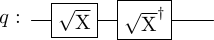

<IPython.core.display.Latex object>

In [53]:
tckt = QuantumCircuit(1)
tckt.sx(0)
tckt.sxdg(0)
tckt.inverse()
tckt.draw('latex')

array_to_latex(Operator(tckt),max_size=16)

In [54]:
def F4_gate():
    FT_ckt=QuantumCircuit(4)
    FT_ckt.append(F_gate(),[0,2])
    FT_ckt.append(F_gate(),[1,3])
    FT_ckt.sdg(3)
    FT_ckt.append(F_gate(),[0,1])
    FT_ckt.append(F_gate(),[2,3])
    FT_ckt.swap(1,2)
    return FT_ckt

def F4_gate_inv():
    FT_ckt=QuantumCircuit(4)
    FT_ckt.swap(1,2)
    FT_ckt.append(Finv_gate(),[2,3])
    FT_ckt.append(Finv_gate(),[0,1])
    FT_ckt.s(3)
    FT_ckt.append(Finv_gate(),[1,3])
    FT_ckt.append(Finv_gate(),[0,2])
    return FT_ckt

Q=4
mmax=2**Q
FT_ckt = QuantumCircuit(4)
FT_ckt.append(F4_gate(),[0,1,2,3])
#FT_ckt.decompose().draw('latex')

qft_ckt_operator=Operator(FT_ckt).data
array_to_latex(qft_ckt_operator[[1,2,4,8],:][:,[1,2,4,8]],max_size=16)

#FT_ckt.append(F4_gate_inv(),[0,1,2,3])
#qft_ckt_operator=Operator(FT_ckt).data
#array_to_latex(qft_ckt_operator,max_size=16)
#array_to_latex(qft_ckt_operator[[1,2,4,8],:][:,[1,2,4,8]],max_size=16)


<IPython.core.display.Latex object>

In [55]:
from scipy import sparse
myzero=np.array([1,0])
myone=np.array([0,1])

Q=8
for i in range(Q):
    if i==0:
        mystate=myone
    else:
        mystate=myzero
    for j in range(1,Q):
        if j==i:
            mystate=np.kron(mystate,myone)
        else:
            mystate=np.kron(mystate,myzero)
    
    print("i=",i)
    print(sparse.csr_matrix(mystate))

i= 0
  (0, 128)	1
i= 1
  (0, 64)	1
i= 2
  (0, 32)	1
i= 3
  (0, 16)	1
i= 4
  (0, 8)	1
i= 5
  (0, 4)	1
i= 6
  (0, 2)	1
i= 7
  (0, 1)	1


# computer phase of an array in multiples of $\pi$

In [68]:
import random
from cmath import polar,phase

#find phases in degrees
def find_phases(X): 

    phase_arr=[]
    for x in X:
        phase_arr.append(phase(x)/np.pi*4)
    
    phase_arr=np.array(phase_arr)
    #phase_arr
    return phase_arr

# F8 gate with SWAP to yield the rotation of the phase as expected:

With this choice of swap we should look at $[0010 \quad 0000]$ for $k_+$ and $[0000 \quad 0010]$ as $k_-$ vector

In [80]:
def F8_gate():
    FT_ckt=QuantumCircuit(8)
    FT_ckt.append(F4_gate(),[0,2,4,6])
    FT_ckt.append(F4_gate(),[1,3,5,7])
    FT_ckt.t(3)
    FT_ckt.sdg(5)
    FT_ckt.t(7)
    FT_ckt.sdg(7)
    FT_ckt.append(F_gate(),[0,1])
    FT_ckt.append(F_gate(),[2,3])
    FT_ckt.append(F_gate(),[4,5])
    FT_ckt.append(F_gate(),[6,7])
    FT_ckt.swap(1,2)
    FT_ckt.swap(2,5)
    FT_ckt.swap(3,7)
    FT_ckt.swap(4,5)
    FT_ckt.swap(5,7)
    FT_ckt.swap(6,7)
    
    return FT_ckt

print("Are the SWAP gates correct at the inverse gate?????????????????????????/")
def F8_gate_inv():
    FT_ckt=QuantumCircuit(8)
    FT_ckt.swap(6,7)
    FT_ckt.swap(5,7)
    FT_ckt.swap(4,5)
    FT_ckt.swap(3,7)
    FT_ckt.swap(2,5)
    FT_ckt.swap(1,2)
    
    FT_ckt.append(Finv_gate(),[6,7])
    FT_ckt.append(Finv_gate(),[4,5])
    FT_ckt.append(Finv_gate(),[2,3])
    FT_ckt.append(Finv_gate(),[0,1])
    FT_ckt.s(7)
    FT_ckt.tdg(7)
    FT_ckt.s(5)
    FT_ckt.tdg(3)
    FT_ckt.append(F4_gate_inv(),[1,3,5,7])
    FT_ckt.append(F4_gate_inv(),[0,2,4,6])
    FT_ckt.swap(1,3)
    FT_ckt.swap(3,5)
    FT_ckt.swap(5,7)
    
    
    return FT_ckt


Q=8
mmax=2**Q
FT_ckt = QuantumCircuit(8)
#FT_ckt.append(F8_gate(),[0,1,2,3,4,5,6,7])

FT_ckt.append(F8_gate_inv(),[0,1,2,3,4,5,6,7])
#FT_ckt.decompose().decompose().draw('latex')


qft_ckt_operator=Operator(FT_ckt).data

inverse_check=0
flag=1
if inverse_check ==0:
    for i in range(len(qft_ckt_operator)):
        for j in range (len(qft_ckt_operator[0])):
            if np.real(qft_ckt_operator[i][j])>1e-10 or np.imag(qft_ckt_operator[i][j])>1e-10:
                if i!=j:
                    print('alarming',i,j,qft_ckt_operator[i][j])
                    flag=0
                    break
        if flag==0:
            break
            
            
fourier_reorder=0
if fourier_reorder:
    mytarget_subspace=[1,2,4,8,16,32,64,128]
    mts=mytarget_subspace
    modified_mytarget_subspace=mts #[mts[0],mts[2],mts[5],mts[7],mts[1],mts[3],mts[4],mts[6]]

    for i in range(len(modified_mytarget_subspace)):
        i,modified_mytarget_subspace[i]
        array_to_latex(find_phases(qft_ckt_operator[mytarget_subspace,mytarget_subspace[i]]),max_size=16)

    array_to_latex( qft_ckt_operator[mytarget_subspace,:][:,mytarget_subspace]/(np.exp(1.0j*np.pi/8)),max_size=16)
    
    
inverse_reorder=1
if inverse_reorder:
    mytarget_subspace=[1,2,4,8,16,32,64,128]
    mts=mytarget_subspace
    modified_mytarget_subspace=[mts[0],mts[2],mts[5],mts[7],mts[1],mts[3],mts[4],mts[6]]

    for i in range(len(modified_mytarget_subspace)):
        i,modified_mytarget_subspace[i]
        array_to_latex(find_phases(qft_ckt_operator[mytarget_subspace,mytarget_subspace[i]]),max_size=16)

    array_to_latex(qft_ckt_operator[mytarget_subspace,:][:,mytarget_subspace],max_size=16)


Are the SWAP gates correct at the inverse gate?????????????????????????/


alarming 1 2 (0.35355339059327373+3.0531133177191805e-16j)


(0, 1)

<IPython.core.display.Latex object>

(1, 4)

<IPython.core.display.Latex object>

(2, 32)

<IPython.core.display.Latex object>

(3, 128)

<IPython.core.display.Latex object>

(4, 2)

<IPython.core.display.Latex object>

(5, 8)

<IPython.core.display.Latex object>

(6, 16)

<IPython.core.display.Latex object>

(7, 64)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

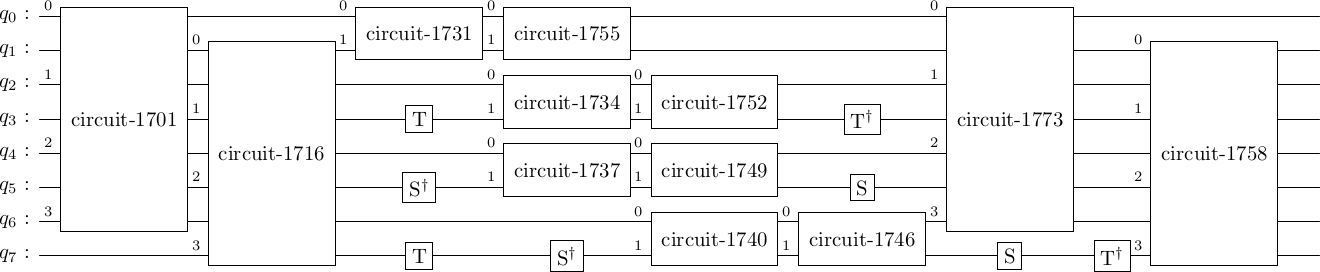

(0, 1)

<IPython.core.display.Latex object>

(1, 4)

<IPython.core.display.Latex object>

(2, 32)

<IPython.core.display.Latex object>

(3, 128)

<IPython.core.display.Latex object>

(4, 2)

<IPython.core.display.Latex object>

(5, 8)

<IPython.core.display.Latex object>

(6, 16)

<IPython.core.display.Latex object>

(7, 64)

<IPython.core.display.Latex object>

In [58]:
def F8_gate():
    FT_ckt=QuantumCircuit(8)
    FT_ckt.append(F4_gate(),[0,2,4,6])
    FT_ckt.append(F4_gate(),[1,3,5,7])
    FT_ckt.t(3)
    FT_ckt.sdg(5)
    FT_ckt.t(7)
    FT_ckt.sdg(7)
    FT_ckt.append(F_gate(),[0,1])
    FT_ckt.append(F_gate(),[2,3])
    FT_ckt.append(F_gate(),[4,5])
    FT_ckt.append(F_gate(),[6,7])
    
    
    
    return FT_ckt

def F8_gate_inv():
    FT_ckt=QuantumCircuit(8)
    
    FT_ckt.append(Finv_gate(),[6,7])
    FT_ckt.append(Finv_gate(),[4,5])
    FT_ckt.append(Finv_gate(),[2,3])
    FT_ckt.append(Finv_gate(),[0,1])
    FT_ckt.s(7)
    FT_ckt.tdg(7)
    FT_ckt.s(5)
    FT_ckt.tdg(3)
    FT_ckt.append(F4_gate_inv(),[1,3,5,7])
    FT_ckt.append(F4_gate_inv(),[0,2,4,6])
    
    
    return FT_ckt


Q=8
mmax=2**Q
FT_ckt = QuantumCircuit(8)
FT_ckt.append(F8_gate(),[0,1,2,3,4,5,6,7])

FT_ckt.append(F8_gate_inv(),[0,1,2,3,4,5,6,7])
FT_ckt.decompose().draw('latex')


qft_ckt_operator=Operator(FT_ckt).data

#array_to_latex(qft_ckt_operator,max_size=16)

inverse_check=1
if inverse_check ==1:
    for i in range(len(qft_ckt_operator)):
        for j in range (len(qft_ckt_operator[0])):
            if qft_ckt_operator[i][j]>1e-10:
                if i!=j:
                    print('alarming')
            

mytarget_subspace=[1,2,4,8,16,32,64,128]
mts=mytarget_subspace
modified_mytarget_subspace=[mts[0],mts[2],mts[5],mts[7],mts[1],mts[3],mts[4],mts[6]]

for i in range(len(modified_mytarget_subspace)):
    i,modified_mytarget_subspace[i]
    array_to_latex(qft_ckt_operator[modified_mytarget_subspace,mytarget_subspace[i]],max_size=16)
    
inverse_prints=0
if inverse_prints:
    for i in mytarget_subspace:
        array_to_latex(qft_ckt_operator[mytarget_subspace,i])

    print("rearrange qubits now to get correct projection for inverse operator")    
    mts=mytarget_subspace
    modified_mytarget_subspace=[mts[0],mts[3],mts[5],mts[7],mts[1],mts[3],mts[4],mts[6]]

    for i in range(len(modified_mytarget_subspace)):
        i,modified_mytarget_subspace[i]
        array_to_latex(qft_ckt_operator[modified_mytarget_subspace,mytarget_subspace[i]],max_size=16)